### Imports

In [53]:
#!pip install msdlib
#!pip3 install torch torchvision torchaudio
#!pip install tqdm
#import torch
#torch.cuda.is_available()
#!pip3 install -U scikit-learn
#!pip install xgboost
#!pip install lightgbm
#!pip install imblearn
#!pip install pyreadstat

In [54]:
#!pip install --upgrade pip
#!pip freeze > requirements_macos.txt
#!pip install -r requirements_macos.txt

In [1]:
!nvidia-smi

Wed Feb  1 10:38:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   37C    P8    12W /  N/A |    435MiB /  8192MiB |     11%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import pandas as pd
from msdlib import msd, mlutils
import joblib
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DTC
from xgboost import XGBClassifier as XGBC
from lightgbm import LGBMClassifier as LGBC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import AdaBoostClassifier as AdaBC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from scipy.special import softmax
from IPython.core.display import HTML
from tqdm import tqdm
import seaborn as sns

/home/ashiskb/venv-directory/venv-ml-p3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [57]:
# result: score matrix
# confus: confusion matrix
# setname: data set name (train or test or validation)
# modelname: name of the prediction model
# savedir: directory path where the graph will be saved
def plot_tables(result, confus, setname, modelname, savedir):
    fig, ax = plt.subplots(figsize = (22, 5), ncols = 2)
    ax[0] = msd.plot_heatmap(result, annotate = True, fmt = '.3f', xrot = 0, vmax = 1, axobj = ax[0], cmap = 'summer', fig_title = 'Score Matrix')
    ax[1] = msd.plot_heatmap(confus, annotate = True, fmt = 'd', xrot = 0, axobj = ax[1], cmap = 'Blues', fig_title = 'Confusion Matrix')
    fig.suptitle('Classification result for %s from %s'%(setname, modelname), fontsize = 15, fontweight = 'bold')
    fig.tight_layout()
    fig.savefig('%s/Classification result for %s from %s.png'%(savedir, setname, modelname), bbox_inches = 'tight')
    plt.show()
    plt.close()

In [58]:
def get_weighted_scores(score, y_test):
    _score = score.copy()
    counts = pd.Series(y_test).value_counts().sort_index().to_frame().T
    _score['weighted_average'] = (_score.drop('accuracy').drop('average', axis=1).values * counts.values / counts.values.sum()).sum(axis=1).tolist()+[_score['average'].loc['accuracy']]
    return _score

In [59]:
# df=pd.read_excel("Desktop/good.xlsx")

In [60]:
#objects = torch.load('Pytorch_model.pt') #This is just a NN model.
#print(type(objects))
#print(objects)

In [105]:
df=pd.read_spss("good.sav")

In [106]:
df.head()

,ADRtotreatment,ASTALTgt1000,ASTALTgt100lt1000,AbdominalPain,Acidosis,Agitation,Alkalosis,Aniongapincreased,Anorexia,Asystole,Ataxia,Bilirubinincreased,Bleedingother,BlistersBullae,Bloodperrectumother,Blurredvision,Bradycardia,Bronchospasm,Burns,Burnssuperficial,Burns23degree,CPKelevated,CVA,Cardiacarrest,Cellulitis,Chestpaininclnoncardiac,Coagulopathyother,Coma,Conductiondisturbance,Confusion,Constipation,Cornealabrasion,Creatinineincreased,Cyanosis,Cytopenia,DIC,Deafness,Dehydration,DermalIrritationpain,Diaphoresis,Diarrhea,Dizzinessvertigo,Drowsinesslethargy,Dysphagia,Dyspnea,DysrhythmiaotherNOS,ECGchangeotherNOS,EPSdystonia,Ecchymosis,Edema,Electrolyteabnormality,Erythemaflushed,Esophagealinjury,Esophagealstricture,Excesssecretions,Fasciculations,Fecalincontinence,Fetaldeath,Feverhyperthermia,Gastricburns,Hallucinationsdelusions,Hematemesis,Hematuria,Hemomyoglobinuria,Hemolysis,Hiveswelts,Hyperglycemia,Hypertension,Hyperventilationtachypnea,Hypoglycemia,Hypotension,Hypothermia,Ileusnobowelsounds,Intracranialbleed,LFTabnormalityother,Lacrimation,Melena,Miosis,MultipleChemicalSensitivities,Musclerigidity,Muscleweakness,Mydriasis,Nausea,Necrosis,Numbness,Nystagmus,Oliguriaanuria,Oralburnsincllips,Oropharyngealedema,Osmolalgapincreased,OtherMiscellaneous,Oxalatecrystalsurine,PTINRprolonged,Pallor,Paralysis,Peripheralneuropathy,Photophobia,Pneumonitis,Polyuria,Pruritus,Pulmonaryedema,Puncturewoundsting,Pupilsnonreactive,Rash,Redeyeconjunctivitis,Renalfailure,Respiratoryarrest,Respiratorydepression,Rhabdomyolysis,Seizuresingle,Seizuresmultidiscrete,Seizuresstatus,Slurredspeech,Syncope,Tachycardia,Throatirritation,Tinnitus,Tremor,Urinaryincontinence,Urinaryretention,Urinecolorchange,VtachycardiaVfibrillation,Visualdefect,Vomiting,Xrayfindings,Age,reason__Intentional,reason__Other,reason__Unintentional,Medical_Outcome__Majoreffect,Medical_Outcome__Minoreffect,Medical_Outcome__Moderateeffect,product,gender__Male
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,1.0,0.0,0.0,0.0,0.0,1.0,Benzodiazepines,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,1.0,0.0,0.0,0.0,0.0,1.0,Diphenhydramine,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,1.0,0.0,0.0,0.0,1.0,0.0,Diphenhydramine,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [63]:
#list all column names~
list(df.columns)

['ADRtotreatment',
 'ASTALTgt1000',
 'ASTALTgt100lt1000',
 'AbdominalPain',
 'Acidosis',
 'Agitation',
 'Alkalosis',
 'Aniongapincreased',
 'Anorexia',
 'Asystole',
 'Ataxia',
 'Bilirubinincreased',
 'Bleedingother',
 'BlistersBullae',
 'Bloodperrectumother',
 'Blurredvision',
 'Bradycardia',
 'Bronchospasm',
 'Burns',
 'Burnssuperficial',
 'Burns23degree',
 'CPKelevated',
 'CVA',
 'Cardiacarrest',
 'Cellulitis',
 'Chestpaininclnoncardiac',
 'Coagulopathyother',
 'Coma',
 'Conductiondisturbance',
 'Confusion',
 'Constipation',
 'Cornealabrasion',
 'Creatinineincreased',
 'Cyanosis',
 'Cytopenia',
 'DIC',
 'Deafness',
 'Dehydration',
 'DermalIrritationpain',
 'Diaphoresis',
 'Diarrhea',
 'Dizzinessvertigo',
 'Drowsinesslethargy',
 'Dysphagia',
 'Dyspnea',
 'DysrhythmiaotherNOS',
 'ECGchangeotherNOS',
 'EPSdystonia',
 'Ecchymosis',
 'Edema',
 'Electrolyteabnormality',
 'Erythemaflushed',
 'Esophagealinjury',
 'Esophagealstricture',
 'Excesssecretions',
 'Fasciculations',
 'Fecalincontine

In [107]:
# removing products to reduce number of target class
del_classes = ['Methadone', 'Oral Hypoglycemics: Biguanides','Bupropion','Calcium Antagonist, Alone']
# del_classes = []

data = df.set_index('product').loc[[i for i in df['product'].unique() if i not in del_classes]].reset_index(drop=False)


In [108]:
data.head()

,product,ADRtotreatment,ASTALTgt1000,ASTALTgt100lt1000,AbdominalPain,Acidosis,Agitation,Alkalosis,Aniongapincreased,Anorexia,Asystole,Ataxia,Bilirubinincreased,Bleedingother,BlistersBullae,Bloodperrectumother,Blurredvision,Bradycardia,Bronchospasm,Burns,Burnssuperficial,Burns23degree,CPKelevated,CVA,Cardiacarrest,Cellulitis,Chestpaininclnoncardiac,Coagulopathyother,Coma,Conductiondisturbance,Confusion,Constipation,Cornealabrasion,Creatinineincreased,Cyanosis,Cytopenia,DIC,Deafness,Dehydration,DermalIrritationpain,Diaphoresis,Diarrhea,Dizzinessvertigo,Drowsinesslethargy,Dysphagia,Dyspnea,DysrhythmiaotherNOS,ECGchangeotherNOS,EPSdystonia,Ecchymosis,Edema,Electrolyteabnormality,Erythemaflushed,Esophagealinjury,Esophagealstricture,Excesssecretions,Fasciculations,Fecalincontinence,Fetaldeath,Feverhyperthermia,Gastricburns,Hallucinationsdelusions,Hematemesis,Hematuria,Hemomyoglobinuria,Hemolysis,Hiveswelts,Hyperglycemia,Hypertension,Hyperventilationtachypnea,Hypoglycemia,Hypotension,Hypothermia,Ileusnobowelsounds,Intracranialbleed,LFTabnormalityother,Lacrimation,Melena,Miosis,MultipleChemicalSensitivities,Musclerigidity,Muscleweakness,Mydriasis,Nausea,Necrosis,Numbness,Nystagmus,Oliguriaanuria,Oralburnsincllips,Oropharyngealedema,Osmolalgapincreased,OtherMiscellaneous,Oxalatecrystalsurine,PTINRprolonged,Pallor,Paralysis,Peripheralneuropathy,Photophobia,Pneumonitis,Polyuria,Pruritus,Pulmonaryedema,Puncturewoundsting,Pupilsnonreactive,Rash,Redeyeconjunctivitis,Renalfailure,Respiratoryarrest,Respiratorydepression,Rhabdomyolysis,Seizuresingle,Seizuresmultidiscrete,Seizuresstatus,Slurredspeech,Syncope,Tachycardia,Throatirritation,Tinnitus,Tremor,Urinaryincontinence,Urinaryretention,Urinecolorchange,VtachycardiaVfibrillation,Visualdefect,Vomiting,Xrayfindings,Age,reason__Intentional,reason__Other,reason__Unintentional,Medical_Outcome__Majoreffect,Medical_Outcome__Minoreffect,Medical_Outcome__Moderateeffect,gender__Male
0,Benzodiazepines,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Benzodiazepines,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,Benzodiazepines,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,Benzodiazepines,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [109]:
data = data.fillna(0)

In [110]:
data.head()

,product,ADRtotreatment,ASTALTgt1000,ASTALTgt100lt1000,AbdominalPain,Acidosis,Agitation,Alkalosis,Aniongapincreased,Anorexia,Asystole,Ataxia,Bilirubinincreased,Bleedingother,BlistersBullae,Bloodperrectumother,Blurredvision,Bradycardia,Bronchospasm,Burns,Burnssuperficial,Burns23degree,CPKelevated,CVA,Cardiacarrest,Cellulitis,Chestpaininclnoncardiac,Coagulopathyother,Coma,Conductiondisturbance,Confusion,Constipation,Cornealabrasion,Creatinineincreased,Cyanosis,Cytopenia,DIC,Deafness,Dehydration,DermalIrritationpain,Diaphoresis,Diarrhea,Dizzinessvertigo,Drowsinesslethargy,Dysphagia,Dyspnea,DysrhythmiaotherNOS,ECGchangeotherNOS,EPSdystonia,Ecchymosis,Edema,Electrolyteabnormality,Erythemaflushed,Esophagealinjury,Esophagealstricture,Excesssecretions,Fasciculations,Fecalincontinence,Fetaldeath,Feverhyperthermia,Gastricburns,Hallucinationsdelusions,Hematemesis,Hematuria,Hemomyoglobinuria,Hemolysis,Hiveswelts,Hyperglycemia,Hypertension,Hyperventilationtachypnea,Hypoglycemia,Hypotension,Hypothermia,Ileusnobowelsounds,Intracranialbleed,LFTabnormalityother,Lacrimation,Melena,Miosis,MultipleChemicalSensitivities,Musclerigidity,Muscleweakness,Mydriasis,Nausea,Necrosis,Numbness,Nystagmus,Oliguriaanuria,Oralburnsincllips,Oropharyngealedema,Osmolalgapincreased,OtherMiscellaneous,Oxalatecrystalsurine,PTINRprolonged,Pallor,Paralysis,Peripheralneuropathy,Photophobia,Pneumonitis,Polyuria,Pruritus,Pulmonaryedema,Puncturewoundsting,Pupilsnonreactive,Rash,Redeyeconjunctivitis,Renalfailure,Respiratoryarrest,Respiratorydepression,Rhabdomyolysis,Seizuresingle,Seizuresmultidiscrete,Seizuresstatus,Slurredspeech,Syncope,Tachycardia,Throatirritation,Tinnitus,Tremor,Urinaryincontinence,Urinaryretention,Urinecolorchange,VtachycardiaVfibrillation,Visualdefect,Vomiting,Xrayfindings,Age,reason__Intentional,reason__Other,reason__Unintentional,Medical_Outcome__Majoreffect,Medical_Outcome__Minoreffect,Medical_Outcome__Moderateeffect,gender__Male
0,Benzodiazepines,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Benzodiazepines,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,Benzodiazepines,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,Benzodiazepines,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [66]:
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', None)

In [29]:
"""
input_units: int, number of units in input layer / number of features (not first hidden layer)
output_units: int, number of units in output layer / number of output nodes / number of classes (not last hidden layer)
unit_factors: array of ints or floats, multipliers to calculate number of units in each hidden layer from input_units, or actual number of units for each hidden layer
dropout_rate: dropout ratio
model_type: {'classification', 'regression'}, controls use of softmax on top of output layer
actual_units: bool, whether actual units are placed in unit_factors or not
"""
def define_layers(input_units, output_units, unit_factors, dropout_rate, model_type, actual_units=False):
    if actual_units:
        hidden_units = unit_factors.copy()
    else:
        hidden_units = [input_units * factor for factor in unit_factors]
    units = [input_units] + hidden_units + [output_units]
    units = [int(i) for i in units]
    
    layers = []
    for i in range(len(unit_factors)):
        layers.append(nn.Linear(units[i], units[i + 1]))
        layers.append(nn.Sigmoid())
        layers.append(nn.BatchNorm1d(units[i + 1]))
        layers.append(nn.Dropout(dropout_rate))
    layers.append(nn.Linear(units[-2], units[-1]))
    if model_type == 'classifier':
        layers.append(nn.Softmax(dim=1))
    return layers

In [67]:
#y_train.values.argmax(axis=1)

In [68]:
#y_train.values.argmax(axis=1)

In [70]:
#y_train.values.argmax(axis=1)

In [71]:
#y_train.values.argmax(axis=1)

In [72]:
#y_train.values.argmax(axis=1)

In [73]:
# storing the models and loading them
def store_models(models, folder_path):
    if not os.path.exists(folder_path): os.makedirs(folder_path)
    for modelname in models:
        print('storing models... %s_model...'%modelname, end='')
        if 'pytorch' in modelname.lower():
            torch.save(models[modelname].model.state_dict(), folder_path + '/%s_model.pt'%modelname)
        else:
            with open(folder_path + '/%s_model.pickle'%modelname, 'wb') as f:
                joblib.dump(models[modelname], f)
        print('   ...storing completed !!')
    
def load_models(models, folder_path):
    for modelname in models:
        print('\rloading models... %s_model...'%modelname, end='')
        if 'pytorch' in modelname.lower():
            models[modelname].model.load_state_dict(torch.load(folder_path + '/%s_model.pt'%modelname))
        else:
            with open(folder_path + '%s_model.pickle'%modelname, 'rb') as f:
                models[modelname] = joblib.load(f)
        print('   ...loading completed !!')
    return models

In [74]:
"""
n_layers: number of hidden layers
offset_factor: makes assymetric structure (base - offset)
max_factor: multiplier for mid layer (largest layer)
base_factor: multiplier for first layer
"""
def get_factors(n_layers, base_factor=5, max_factor=10, offset_factor=2):
    base_factor = max_factor - base_factor
    return [max_factor - abs(x) for x in np.linspace(-base_factor, base_factor + offset_factor, n_layers) if max_factor - abs(x) > 0]

In [75]:
def prepare_row(age, product, outcome, therapy, effects, zeros, val2index, columns):
    # adding the data to stack
    _zeros = {key: zeros[key].copy() for key in zeros}
    # stacking clinical effect
    for k in effects: _zeros['Clinical_Effect'][val2index['Clinical_Effect'][k]] = 1
    for k in therapy: _zeros['Therapy'][val2index['Therapy'][k]] = 1
    # stacking medical outcome
    _zeros['Medical_Outcome'][val2index['Medical_Outcome'][outcome]] = 1
    # combining
    row = np.concatenate([[age]] + [_zeros[col] for col in columns] + [[product]], axis=0)
    return row

In [76]:
def prepare_data(_rawdata, ):
    
    rawdata = _rawdata.copy()
    # filling nan values
    for c in rawdata.columns:
        rawdata[c] = rawdata[c].fillna('NAN').replace(' ', '').replace('', 'NAN')
    
    # extrcting data from rows
    columns = ['Clinical_Effect', 'Therapy', 'Medical_Outcome']
    val2index = {col: {k: i for i, k in enumerate(np.sort(rawdata[col].unique()))} for col in columns}
    zeros = {col: np.zeros(rawdata[col].unique().shape[0]) for col in columns}

    # initializing counts
    product = rawdata['Product'].iloc[0]
    age = rawdata['Age'].iloc[0]
    effects = [rawdata['Clinical_Effect'].iloc[0]]
    outcome = rawdata['Medical_Outcome'].iloc[0]
    therapy = [rawdata['Therapy'].iloc[0]]
    root_index = [0]
    data_stack = []
    for i in tqdm(range(1, rawdata.shape[0])):
        if rawdata['Product'].iloc[i] != 'NAN':
            row = prepare_row(age, product, outcome, therapy, effects, zeros, val2index, columns)
            data_stack.append(row)
            # initializing again
            product = rawdata['Product'].iloc[i]
            age = rawdata['Age'].iloc[i]
            effects = [rawdata['Clinical_Effect'].iloc[i]]
            outcome = rawdata['Medical_Outcome'].iloc[i]
            therapy = [rawdata['Therapy'].iloc[i]]
            root_index.append(i)
        else:
            # appending effects
            effects.append(rawdata['Clinical_Effect'].iloc[i])
            therapy.append(rawdata['Therapy'].iloc[i])
    row = prepare_row(age, product, outcome, therapy, effects, zeros, val2index, columns)
    data_stack.append(row)
    
    cols = ['%s: %s'%(col, k) for col in columns for k in pd.Series(val2index[col]).to_frame(col).reset_index(drop=False).set_index(col).sort_index()['index'].to_list()]
    return pd.DataFrame(np.array(data_stack), columns=['Age'] + cols + ['Product']), root_index

### (X) Data Loading

In [143]:
rawdata = pd.read_spss('final.csv.for abdullah.sav').replace('', np.nan).drop('productnew', axis=1)
rawdata['Medical_Outcome'].iloc[0] = 'Minor effect'
rawdata['Therapy'].iloc[0] = 'Fluids, IV'
rawdata

PyreadstatError: File final.csv.for abdullah.sav does not exist!

In [144]:
# total products found
rawdata['Product'].dropna().shape

NameError: name 'rawdata' is not defined

### Process data to create one hot table for categorical features

In [145]:
newdata, raw_index = prepare_data(rawdata)
for c in newdata.columns:
    if c == 'Age': newdata[c] = newdata[c].values.astype(float)
    elif c == 'Product': pass
    else: newdata[c] = newdata[c].values.astype(float).astype(int)

newdata.to_pickle('raw_to_processed_data.pickle')

NameError: name 'rawdata' is not defined

### (AshisKB) Prepare training data set 'data'

In [146]:
# # newdata = pd.read_pickle('raw_to_processed_data.pickle')
# newdata=pd.read_excel("Desktop/good.xlsx")
# newdata

In [85]:
data=pd.read_spss("good.sav")


In [86]:
data.head()

,ADRtotreatment,ASTALTgt1000,ASTALTgt100lt1000,AbdominalPain,Acidosis,Agitation,Alkalosis,Aniongapincreased,Anorexia,Asystole,Ataxia,Bilirubinincreased,Bleedingother,BlistersBullae,Bloodperrectumother,Blurredvision,Bradycardia,Bronchospasm,Burns,Burnssuperficial,Burns23degree,CPKelevated,CVA,Cardiacarrest,Cellulitis,Chestpaininclnoncardiac,Coagulopathyother,Coma,Conductiondisturbance,Confusion,Constipation,Cornealabrasion,Creatinineincreased,Cyanosis,Cytopenia,DIC,Deafness,Dehydration,DermalIrritationpain,Diaphoresis,Diarrhea,Dizzinessvertigo,Drowsinesslethargy,Dysphagia,Dyspnea,DysrhythmiaotherNOS,ECGchangeotherNOS,EPSdystonia,Ecchymosis,Edema,Electrolyteabnormality,Erythemaflushed,Esophagealinjury,Esophagealstricture,Excesssecretions,Fasciculations,Fecalincontinence,Fetaldeath,Feverhyperthermia,Gastricburns,Hallucinationsdelusions,Hematemesis,Hematuria,Hemomyoglobinuria,Hemolysis,Hiveswelts,Hyperglycemia,Hypertension,Hyperventilationtachypnea,Hypoglycemia,Hypotension,Hypothermia,Ileusnobowelsounds,Intracranialbleed,LFTabnormalityother,Lacrimation,Melena,Miosis,MultipleChemicalSensitivities,Musclerigidity,Muscleweakness,Mydriasis,Nausea,Necrosis,Numbness,Nystagmus,Oliguriaanuria,Oralburnsincllips,Oropharyngealedema,Osmolalgapincreased,OtherMiscellaneous,Oxalatecrystalsurine,PTINRprolonged,Pallor,Paralysis,Peripheralneuropathy,Photophobia,Pneumonitis,Polyuria,Pruritus,Pulmonaryedema,Puncturewoundsting,Pupilsnonreactive,Rash,Redeyeconjunctivitis,Renalfailure,Respiratoryarrest,Respiratorydepression,Rhabdomyolysis,Seizuresingle,Seizuresmultidiscrete,Seizuresstatus,Slurredspeech,Syncope,Tachycardia,Throatirritation,Tinnitus,Tremor,Urinaryincontinence,Urinaryretention,Urinecolorchange,VtachycardiaVfibrillation,Visualdefect,Vomiting,Xrayfindings,Age,reason__Intentional,reason__Other,reason__Unintentional,Medical_Outcome__Majoreffect,Medical_Outcome__Minoreffect,Medical_Outcome__Moderateeffect,product,gender__Male
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,1.0,0.0,0.0,0.0,0.0,1.0,Benzodiazepines,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,1.0,0.0,0.0,0.0,0.0,1.0,Diphenhydramine,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,1.0,0.0,0.0,0.0,1.0,0.0,Diphenhydramine,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

#### Verification of data set organizing process

In [147]:
# i = 10100
# idx1, idx2 = rawdata['Product'].dropna().index[i], rawdata['Product'].dropna().index[i+1]
# idx1, idx2

In [148]:
# rawdata.iloc[idx1: idx2+1]

In [149]:
# newdata.iloc[i][newdata.iloc[i].astype(bool)].to_frame().T

In [150]:
# # selecting only clinical effect features
# effect_cols = [c for c in newdata.columns if 'Clinical_Effect:' in c]
# data = pd.DataFrame(newdata[effect_cols].copy())
# data.columns = [k.replace('Clinical_Effect: ', '') for k in data.columns]
# data['product'] = newdata['product'].copy()
# data

In [37]:
# available products
data['product'].unique()

array(['Benzodiazepines', 'Diphenhydramine', 'Bupropion',
       'Acetylsalicylic Acid Alone', 'Acetaminophen', 'Methadone',
       'Lithium', 'Oral Hypoglycemics: Sulfonylureas',
       'Calcium Antagonist, Alone', 'Oral Hypoglycemics: Biguanides'],
      dtype=object)

In [87]:
# removing products to reduce number of target class
del_classes = ['Methadone', 'Oral Hypoglycemics: Biguanides','Bupropion','Calcium Antagonist, Alone']
# del_classes = []

data = data.set_index('product').loc[[i for i in data['product'].unique() if i not in del_classes]].reset_index(drop=False)





In [88]:
data.head()

,product,ADRtotreatment,ASTALTgt1000,ASTALTgt100lt1000,AbdominalPain,Acidosis,Agitation,Alkalosis,Aniongapincreased,Anorexia,Asystole,Ataxia,Bilirubinincreased,Bleedingother,BlistersBullae,Bloodperrectumother,Blurredvision,Bradycardia,Bronchospasm,Burns,Burnssuperficial,Burns23degree,CPKelevated,CVA,Cardiacarrest,Cellulitis,Chestpaininclnoncardiac,Coagulopathyother,Coma,Conductiondisturbance,Confusion,Constipation,Cornealabrasion,Creatinineincreased,Cyanosis,Cytopenia,DIC,Deafness,Dehydration,DermalIrritationpain,Diaphoresis,Diarrhea,Dizzinessvertigo,Drowsinesslethargy,Dysphagia,Dyspnea,DysrhythmiaotherNOS,ECGchangeotherNOS,EPSdystonia,Ecchymosis,Edema,Electrolyteabnormality,Erythemaflushed,Esophagealinjury,Esophagealstricture,Excesssecretions,Fasciculations,Fecalincontinence,Fetaldeath,Feverhyperthermia,Gastricburns,Hallucinationsdelusions,Hematemesis,Hematuria,Hemomyoglobinuria,Hemolysis,Hiveswelts,Hyperglycemia,Hypertension,Hyperventilationtachypnea,Hypoglycemia,Hypotension,Hypothermia,Ileusnobowelsounds,Intracranialbleed,LFTabnormalityother,Lacrimation,Melena,Miosis,MultipleChemicalSensitivities,Musclerigidity,Muscleweakness,Mydriasis,Nausea,Necrosis,Numbness,Nystagmus,Oliguriaanuria,Oralburnsincllips,Oropharyngealedema,Osmolalgapincreased,OtherMiscellaneous,Oxalatecrystalsurine,PTINRprolonged,Pallor,Paralysis,Peripheralneuropathy,Photophobia,Pneumonitis,Polyuria,Pruritus,Pulmonaryedema,Puncturewoundsting,Pupilsnonreactive,Rash,Redeyeconjunctivitis,Renalfailure,Respiratoryarrest,Respiratorydepression,Rhabdomyolysis,Seizuresingle,Seizuresmultidiscrete,Seizuresstatus,Slurredspeech,Syncope,Tachycardia,Throatirritation,Tinnitus,Tremor,Urinaryincontinence,Urinaryretention,Urinecolorchange,VtachycardiaVfibrillation,Visualdefect,Vomiting,Xrayfindings,Age,reason__Intentional,reason__Other,reason__Unintentional,Medical_Outcome__Majoreffect,Medical_Outcome__Minoreffect,Medical_Outcome__Moderateeffect,gender__Male
0,Benzodiazepines,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Benzodiazepines,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,Benzodiazepines,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,Benzodiazepines,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [89]:
# checking nan values if any
print(data.info())
data.isnull().sum().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185758 entries, 0 to 185757
Columns: 134 entries, product to gender__Male
dtypes: float64(133), object(1)
memory usage: 189.9+ MB
None


0

In [90]:
data.nunique().unique()

array([  6,   2,   1, 111])

In [91]:
# checking number of labels in each class
data['product'].value_counts()

Benzodiazepines                      68536
Diphenhydramine                      51798
Acetaminophen                        38033
Acetylsalicylic Acid Alone           15268
Lithium                               9434
Oral Hypoglycemics: Sulfonylureas     2689
Name: product, dtype: int64

## Data Processing

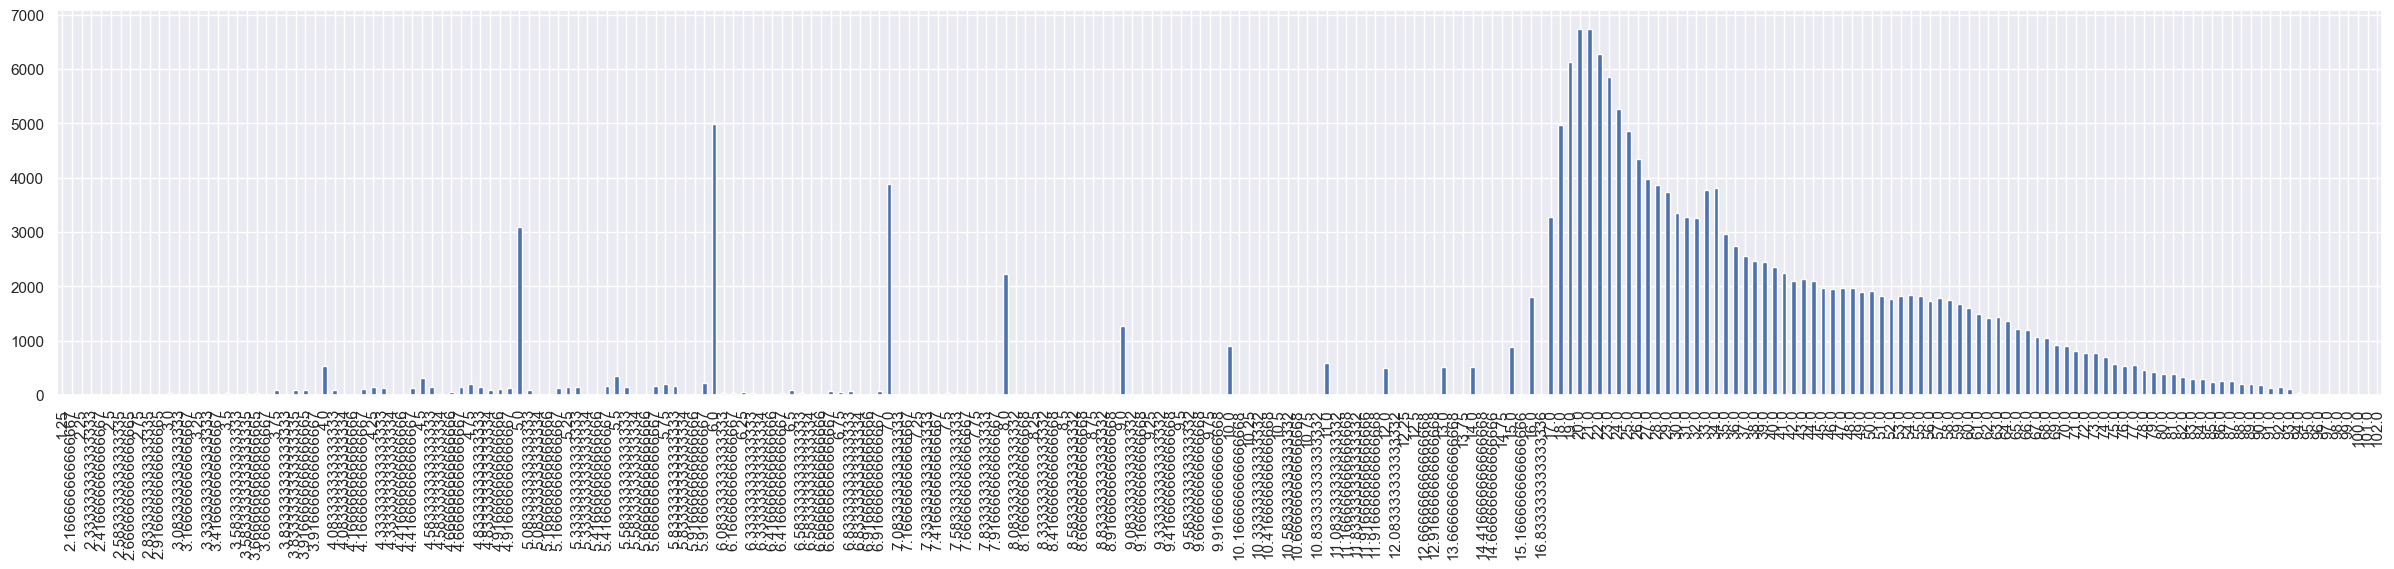

In [92]:
# # sample count (y-axis) for various number of clinical features (x axis)
rowsum = data.drop('product', axis=1).sum(axis=1)
rowsum.value_counts().sort_index().plot(kind='bar', figsize=(30, 5))
plt.show()

In [78]:
rowsum.value_counts()

21.000000    6746
20.000000    6742
22.000000    6276
19.000000    6136
23.000000    5854
             ... 
10.666667       1
10.833333       1
4.083333        1
11.166667       1
16.833333       1
Length: 239, dtype: int64

In [80]:
# # checking samples where only one clinical feature is present
num = 1
numdata = data.loc[rowsum[rowsum == num].index].drop('product', axis=1)
idx = np.where(numdata.astype(bool))
idx

(array([], dtype=int64), array([], dtype=int64))

In [81]:
# # real index from 'data'
numdata.index

Int64Index([], dtype='int64')

#### remove all indices/data where only one clinical effect is present

In [82]:
data.drop(numdata.index, axis=0, inplace=True)
data

,product,ADRtotreatment,ASTALTgt1000,ASTALTgt100lt1000,AbdominalPain,Acidosis,Agitation,Alkalosis,Aniongapincreased,Anorexia,Asystole,Ataxia,Bilirubinincreased,Bleedingother,BlistersBullae,Bloodperrectumother,Blurredvision,Bradycardia,Bronchospasm,Burns,Burnssuperficial,Burns23degree,CPKelevated,CVA,Cardiacarrest,Cellulitis,Chestpaininclnoncardiac,Coagulopathyother,Coma,Conductiondisturbance,Confusion,Constipation,Cornealabrasion,Creatinineincreased,Cyanosis,Cytopenia,DIC,Deafness,Dehydration,DermalIrritationpain,Diaphoresis,Diarrhea,Dizzinessvertigo,Drowsinesslethargy,Dysphagia,Dyspnea,DysrhythmiaotherNOS,ECGchangeotherNOS,EPSdystonia,Ecchymosis,Edema,Electrolyteabnormality,Erythemaflushed,Esophagealinjury,Esophagealstricture,Excesssecretions,Fasciculations,Fecalincontinence,Fetaldeath,Feverhyperthermia,Gastricburns,Hallucinationsdelusions,Hematemesis,Hematuria,Hemomyoglobinuria,Hemolysis,Hiveswelts,Hyperglycemia,Hypertension,Hyperventilationtachypnea,Hypoglycemia,Hypotension,Hypothermia,Ileusnobowelsounds,Intracranialbleed,LFTabnormalityother,Lacrimation,Melena,Miosis,MultipleChemicalSensitivities,Musclerigidity,Muscleweakness,Mydriasis,Nausea,Necrosis,Numbness,Nystagmus,Oliguriaanuria,Oralburnsincllips,Oropharyngealedema,Osmolalgapincreased,OtherMiscellaneous,Oxalatecrystalsurine,PTINRprolonged,Pallor,Paralysis,Peripheralneuropathy,Photophobia,Pneumonitis,Polyuria,Pruritus,Pulmonaryedema,Puncturewoundsting,Pupilsnonreactive,Rash,Redeyeconjunctivitis,Renalfailure,Respiratoryarrest,Respiratorydepression,Rhabdomyolysis,Seizuresingle,Seizuresmultidiscrete,Seizuresstatus,Slurredspeech,Syncope,Tachycardia,Throatirritation,Tinnitus,Tremor,Urinaryincontinence,Urinaryretention,Urinecolorchange,VtachycardiaVfibrillation,Visualdefect,Vomiting,Xrayfindings,Age,reason__Intentional,reason__Other,reason__Unintentional,Medical_Outcome__Majoreffect,Medical_Outcome__Minoreffect,Medical_Outcome__Moderateeffect,gender__Male
0,Benzodiazepines,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.000000,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Benzodiazepines,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,Benzodiazepines,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,Benzodiazepines,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

#### Remove only ambiguous indices where one clinical effect is present for minority classes

In [83]:
counts = []
columns = data.drop('product', axis=1).columns
for i in np.sort(np.unique(idx[1])):
    counts.append(data.loc[numdata.index[np.where(idx[1] == i)[0]]]['product'].value_counts().rename(columns[i]))
counts = pd.concat(counts, axis=1, sort=False)
counts.index = counts.index.to_list()
counts = pd.concat([counts, counts.sum().to_frame('sum').T, (counts.sum() - counts.max()).to_frame('# minority class instance').T], axis=0, sort=False)
counts

ValueError: No objects to concatenate

In [84]:
# # collecting invalid indices based on minority classes
invalid_indices = []

for feature in counts.columns:
    indices = numdata.index[idx[0][np.where(idx[1] == np.where(columns == feature)[0][0])[0]]].to_list()
    dom_feat = counts[feature].iloc[:-2].idxmax()
    rem_idx = data.loc[indices].reset_index(drop=False).set_index('product').drop(dom_feat, axis=0)['index'].to_list()
    invalid_indices += rem_idx
invalid_indices = sorted(invalid_indices)

# # removing samples that are invalid
data.drop(invalid_indices, axis=0, inplace=True)

AttributeError: 'list' object has no attribute 'columns'

### Additional data visualization

In [117]:
# ratios = pd.Series(data.set_index('product').sum()/data.shape[0], name='ratio_1').to_frame()
# ratios['ratio_0'] = 1 - ratios['ratio_1']
# ratios.plot(kind='bar', figsize=(35, 6), title='ratio of 1 and 0 for all features', stacked=True)
# plt.show()

In [118]:
# # ratio of 1 in different classes
# feature_ratios = []
# _data = data.set_index('product')
# for c in data.columns.drop('product'):
#     print(c)
#     temp = _data[c][_data[c].astype(bool)]
#     feature_ratios.append((temp.index.value_counts() / temp.shape[0]).rename(c))
# feature_ratios = pd.concat(feature_ratios, axis=1, sort=False)
# msd.plot_heatmap(feature_ratios, figsize=(40, 9))

In [119]:
# feature_ratios.T.plot.barh(figsize=(10, 40), stacked=True)
# plt.show()

In [120]:
# onlydata = data.drop('product', axis=1).copy()
# label = data['product'].copy()

In [121]:
# thres = .5

# featsum = onlydata.sum()
# sel_features = []
# for _class in label.unique():
#     idx = label == _class
#     featratio = (onlydata[idx].sum() / featsum).to_frame('feature_coverage')
#     featratio['class_coverage'] = onlydata[idx].sum() / idx.sum()
#     sel_features += featratio['feature_coverage'][featratio['feature_coverage'] >= thres].index.to_list()
#     featratio.plot.bar(figsize=(30, 6), title='%s feature distribution'%_class)
#     plt.show()
# sel_features

In [122]:
# onlydata[sel_features].shape

## (AshisKB) Data set management

In [111]:
# label names to index mapping and reverse mapping
label2index = {k: i for i, k in enumerate(np.sort(data['product'].unique()))}
index2label = {label2index[k]: k for k in label2index}
print(label2index)
print(index2label)

{'Acetaminophen': 0, 'Acetylsalicylic Acid Alone': 1, 'Benzodiazepines': 2, 'Diphenhydramine': 3, 'Lithium': 4, 'Oral Hypoglycemics: Sulfonylureas': 5}
{0: 'Acetaminophen', 1: 'Acetylsalicylic Acid Alone', 2: 'Benzodiazepines', 3: 'Diphenhydramine', 4: 'Lithium', 5: 'Oral Hypoglycemics: Sulfonylureas'}


### Statistical feature importance (isnt used though in later stages)

Evaluation for label : product (Categorical label) ....

/Users/ashis/venv-directory/venv-ml-p3.10/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


  done


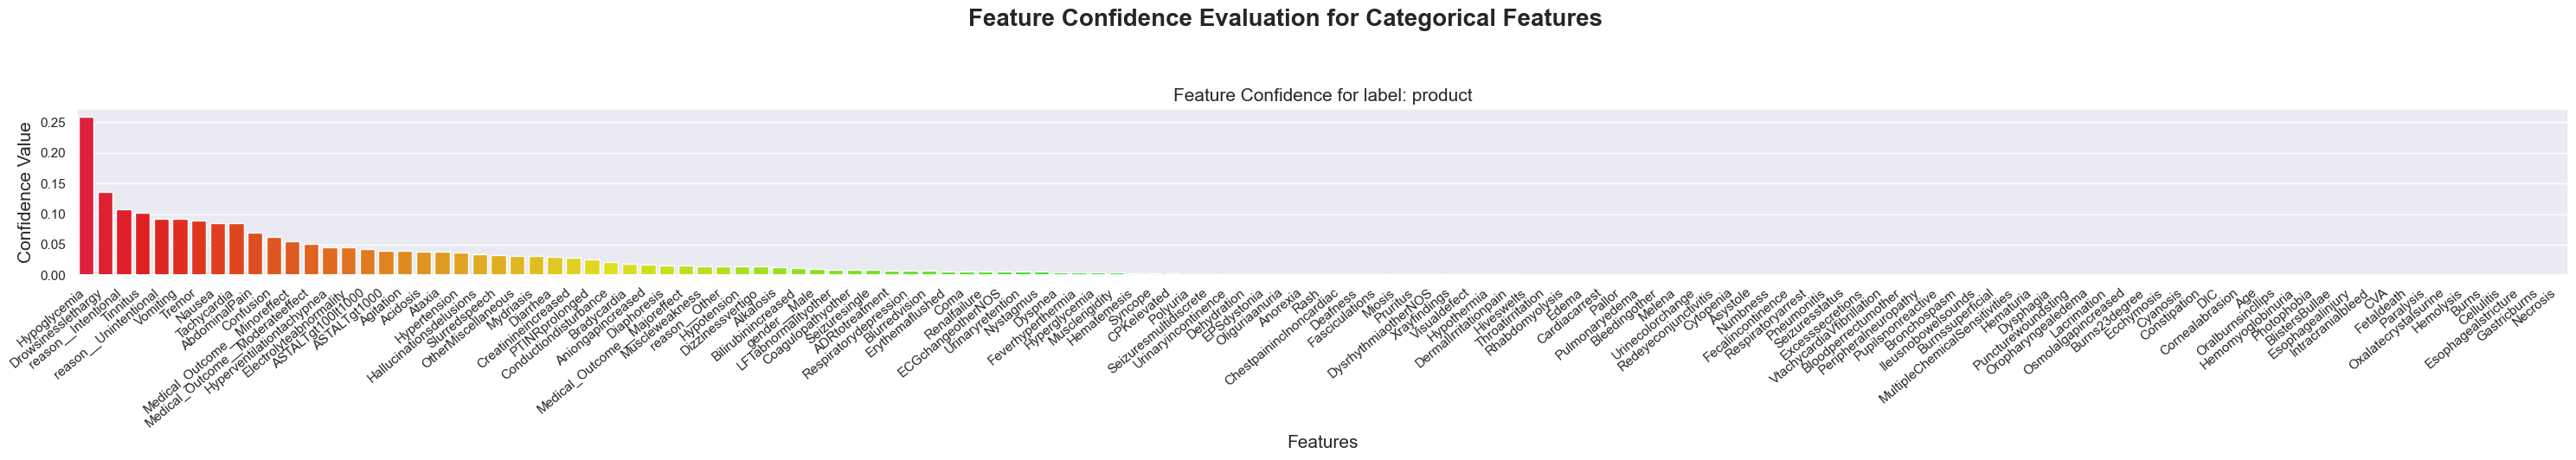

['Hypoglycemia',
 'Drowsinesslethargy',
 'reason__Intentional',
 'Tinnitus',
 'reason__Unintentional',
 'Vomiting',
 'Tremor',
 'Nausea',
 'Tachycardia',
 'AbdominalPain',
 'Confusion',
 'Medical_Outcome__Minoreffect',
 'Medical_Outcome__Moderateeffect',
 'Hyperventilationtachypnea',
 'Electrolyteabnormality',
 'ASTALTgt100lt1000',
 'ASTALTgt1000',
 'Agitation',
 'Acidosis',
 'Ataxia',
 'Hypertension',
 'Hallucinationsdelusions',
 'Slurredspeech',
 'OtherMiscellaneous',
 'Mydriasis',
 'Diarrhea',
 'Creatinineincreased',
 'PTINRprolonged',
 'Conductiondisturbance',
 'Bradycardia',
 'Aniongapincreased',
 'Diaphoresis']

In [113]:
# feature importance analysis
data['product'] = data['product'].replace(label2index)
confidence = msd.feature_evaluator(data, label_name=['product'], label_type_num=[False], is_all_cat = True, cmap = 'gist_rainbow', fig_width = 30, fig_height = 5, rotation = 40, show = True, save = False, 
                                   savepath = None, fname = None)
sel_features = confidence['Categorical label']['product_categs'].loc[:, :'Diaphoresis'].columns.to_list()
sel_features

### Data preparation for training and testing

In [114]:
data.head()

,product,ADRtotreatment,ASTALTgt1000,ASTALTgt100lt1000,AbdominalPain,Acidosis,Agitation,Alkalosis,Aniongapincreased,Anorexia,Asystole,Ataxia,Bilirubinincreased,Bleedingother,BlistersBullae,Bloodperrectumother,Blurredvision,Bradycardia,Bronchospasm,Burns,Burnssuperficial,Burns23degree,CPKelevated,CVA,Cardiacarrest,Cellulitis,Chestpaininclnoncardiac,Coagulopathyother,Coma,Conductiondisturbance,Confusion,Constipation,Cornealabrasion,Creatinineincreased,Cyanosis,Cytopenia,DIC,Deafness,Dehydration,DermalIrritationpain,Diaphoresis,Diarrhea,Dizzinessvertigo,Drowsinesslethargy,Dysphagia,Dyspnea,DysrhythmiaotherNOS,ECGchangeotherNOS,EPSdystonia,Ecchymosis,Edema,Electrolyteabnormality,Erythemaflushed,Esophagealinjury,Esophagealstricture,Excesssecretions,Fasciculations,Fecalincontinence,Fetaldeath,Feverhyperthermia,Gastricburns,Hallucinationsdelusions,Hematemesis,Hematuria,Hemomyoglobinuria,Hemolysis,Hiveswelts,Hyperglycemia,Hypertension,Hyperventilationtachypnea,Hypoglycemia,Hypotension,Hypothermia,Ileusnobowelsounds,Intracranialbleed,LFTabnormalityother,Lacrimation,Melena,Miosis,MultipleChemicalSensitivities,Musclerigidity,Muscleweakness,Mydriasis,Nausea,Necrosis,Numbness,Nystagmus,Oliguriaanuria,Oralburnsincllips,Oropharyngealedema,Osmolalgapincreased,OtherMiscellaneous,Oxalatecrystalsurine,PTINRprolonged,Pallor,Paralysis,Peripheralneuropathy,Photophobia,Pneumonitis,Polyuria,Pruritus,Pulmonaryedema,Puncturewoundsting,Pupilsnonreactive,Rash,Redeyeconjunctivitis,Renalfailure,Respiratoryarrest,Respiratorydepression,Rhabdomyolysis,Seizuresingle,Seizuresmultidiscrete,Seizuresstatus,Slurredspeech,Syncope,Tachycardia,Throatirritation,Tinnitus,Tremor,Urinaryincontinence,Urinaryretention,Urinecolorchange,VtachycardiaVfibrillation,Visualdefect,Vomiting,Xrayfindings,Age,reason__Intentional,reason__Other,reason__Unintentional,Medical_Outcome__Majoreffect,Medical_Outcome__Minoreffect,Medical_Outcome__Moderateeffect,gender__Male
0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [115]:
list(data.columns)

['product',
 'ADRtotreatment',
 'ASTALTgt1000',
 'ASTALTgt100lt1000',
 'AbdominalPain',
 'Acidosis',
 'Agitation',
 'Alkalosis',
 'Aniongapincreased',
 'Anorexia',
 'Asystole',
 'Ataxia',
 'Bilirubinincreased',
 'Bleedingother',
 'BlistersBullae',
 'Bloodperrectumother',
 'Blurredvision',
 'Bradycardia',
 'Bronchospasm',
 'Burns',
 'Burnssuperficial',
 'Burns23degree',
 'CPKelevated',
 'CVA',
 'Cardiacarrest',
 'Cellulitis',
 'Chestpaininclnoncardiac',
 'Coagulopathyother',
 'Coma',
 'Conductiondisturbance',
 'Confusion',
 'Constipation',
 'Cornealabrasion',
 'Creatinineincreased',
 'Cyanosis',
 'Cytopenia',
 'DIC',
 'Deafness',
 'Dehydration',
 'DermalIrritationpain',
 'Diaphoresis',
 'Diarrhea',
 'Dizzinessvertigo',
 'Drowsinesslethargy',
 'Dysphagia',
 'Dyspnea',
 'DysrhythmiaotherNOS',
 'ECGchangeotherNOS',
 'EPSdystonia',
 'Ecchymosis',
 'Edema',
 'Electrolyteabnormality',
 'Erythemaflushed',
 'Esophagealinjury',
 'Esophagealstricture',
 'Excesssecretions',
 'Fasciculations',
 'Fe

In [116]:
# separating label
label = data['product'].copy()
# removing samples where the only clinical feature is NAN
#data = data.drop(data.index[data.drop('NAN', axis=1).sum(axis=1) == 0], axis=0)
#data = data.fillna(0)
# removing NAN and label from data set
data.drop(['product'], axis=1, inplace=True)


In [117]:
data.head()

,ADRtotreatment,ASTALTgt1000,ASTALTgt100lt1000,AbdominalPain,Acidosis,Agitation,Alkalosis,Aniongapincreased,Anorexia,Asystole,Ataxia,Bilirubinincreased,Bleedingother,BlistersBullae,Bloodperrectumother,Blurredvision,Bradycardia,Bronchospasm,Burns,Burnssuperficial,Burns23degree,CPKelevated,CVA,Cardiacarrest,Cellulitis,Chestpaininclnoncardiac,Coagulopathyother,Coma,Conductiondisturbance,Confusion,Constipation,Cornealabrasion,Creatinineincreased,Cyanosis,Cytopenia,DIC,Deafness,Dehydration,DermalIrritationpain,Diaphoresis,Diarrhea,Dizzinessvertigo,Drowsinesslethargy,Dysphagia,Dyspnea,DysrhythmiaotherNOS,ECGchangeotherNOS,EPSdystonia,Ecchymosis,Edema,Electrolyteabnormality,Erythemaflushed,Esophagealinjury,Esophagealstricture,Excesssecretions,Fasciculations,Fecalincontinence,Fetaldeath,Feverhyperthermia,Gastricburns,Hallucinationsdelusions,Hematemesis,Hematuria,Hemomyoglobinuria,Hemolysis,Hiveswelts,Hyperglycemia,Hypertension,Hyperventilationtachypnea,Hypoglycemia,Hypotension,Hypothermia,Ileusnobowelsounds,Intracranialbleed,LFTabnormalityother,Lacrimation,Melena,Miosis,MultipleChemicalSensitivities,Musclerigidity,Muscleweakness,Mydriasis,Nausea,Necrosis,Numbness,Nystagmus,Oliguriaanuria,Oralburnsincllips,Oropharyngealedema,Osmolalgapincreased,OtherMiscellaneous,Oxalatecrystalsurine,PTINRprolonged,Pallor,Paralysis,Peripheralneuropathy,Photophobia,Pneumonitis,Polyuria,Pruritus,Pulmonaryedema,Puncturewoundsting,Pupilsnonreactive,Rash,Redeyeconjunctivitis,Renalfailure,Respiratoryarrest,Respiratorydepression,Rhabdomyolysis,Seizuresingle,Seizuresmultidiscrete,Seizuresstatus,Slurredspeech,Syncope,Tachycardia,Throatirritation,Tinnitus,Tremor,Urinaryincontinence,Urinaryretention,Urinecolorchange,VtachycardiaVfibrillation,Visualdefect,Vomiting,Xrayfindings,Age,reason__Intentional,reason__Other,reason__Unintentional,Medical_Outcome__Majoreffect,Medical_Outcome__Minoreffect,Medical_Outcome__Moderateeffect,gender__Male
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,

In [118]:
# data set splitting into training and test data
val_ratio = .30
test_ratio = 0
splitter = msd.SplitDataset(data, label, index = data.index, test_ratio = test_ratio, same_ratio = True)
outdata = splitter.random_split(val_ratio)
outdata.keys()

dict_keys(['train', 'validation', 'test'])

In [119]:
outdata['train']['data'].shape

(130034, 133)

### Defining models

In [120]:
# Deep NN model parameters
params = {'optimizer': torch.optim.Adam,
          'loss_func': nn.CrossEntropyLoss,
          'learning_rate': .001,
          'lr_reduce': .99,
          'epoch': 5,
          'loss_reduction': 'mean',    # loss function reduction metric
          'batch_size': 4096,
          'model_type': 'classifier',
          'use_gpu': True,
          'plot_loss': True,
          'quant_perc': .97,
          'plot_true_pred': False}

n_layers = 4
unit_factors = get_factors(n_layers=n_layers)
dropout_rate = .15

In [129]:
np.unique(outdata['train']['label'][:, 0])

array([0, 1, 2, 3, 4, 5])

In [130]:
seg = 20
min_sec_factor = .75
#classes = pd.Series({0: 5, 1: 2, 2: 10, 3: 2, 4: 1, 5: 6, 6: 2,7:1}, name='division')
classes = pd.Series({0: 5, 1: 2, 2: 10, 3: 2, 4: 1, 5: 6}, name='division')
#classes = pd.Series({0: 5, 1: 2, 2: 10, 3: 1, 4: 6, 5: 2, 6: 1}, name='division')

lens = pd.Series(outdata['train']['label'][:, 0]).value_counts().rename('n_samples')
splitdf = pd.concat([lens, classes], axis=1, sort=True)


In [131]:
splitdf

,n_samples,division
0,26624,5
1,10688,2
2,47976,10
3,36259,2
4,6604,1
5,1883,6


In [132]:
splitdf['sec_len'] = (splitdf['n_samples'] / splitdf['division']).astype(int)


In [133]:
indices = {i: outdata['train']['label']==i for i in np.sort(np.unique(outdata['train']['label'])).astype(int)}
display(splitdf)

,n_samples,division,sec_len
0,26624,5,5324
1,10688,2,5344
2,47976,10,4797
3,36259,2,18129
4,6604,1,6604
5,1883,6,313


### (AshisKB) Training all models and evaluating them

In [150]:
avg_scores = []
if not os.path.exists('confusion_matrices/'): os.makedirs('confusion_matrices/')
if not os.path.exists('figures/evaluation_figures/'): os.makedirs('figures/evaluation_figures/')
for test_ratio in [.15,]:
    _avgscore = []
    layers = define_layers(outdata['train']['data'].shape[1], len(label2index), unit_factors, dropout_rate, params['model_type'])
    models = {#'Pytorch': mlutils.torchModel(layers, **params),
#           'KNN' : KNN(6), 
#           'DT' : DTC(max_depth = 10, ),
          'XGBoost' : XGBC(),
          'LGBM' : LGBC(), 
#           'RandomForest' : RFC(),
#           'AdaBoost': AdaBC(),
#           'LinearReg' : LR(multi_class = 'ovr')
             }
    for n in range(seg):
        print('Segment: %d / %d'%(n + 1, seg))
        Xtrain = []
        Ytrain = []
        for i in splitdf.index:
            st = (n % (indices[i].sum() // splitdf['sec_len'].loc[i])) * splitdf['sec_len'].loc[i]
            ed = ((n + 1) % (indices[i].sum() // splitdf['sec_len'].loc[i])) * splitdf['sec_len'].loc[i]
            if st == 0 and ed == 0: ed = indices[i].sum()
            elif st != 0 and ed == 0:
                if indices[i].sum() - st > splitdf['sec_len'].loc[i] * min_sec_factor:
                    ed = indices[i].sum()
                else:
                    st, ed = 0, splitdf['sec_len'].loc[i]
            Xtrain.append(outdata['train']['data'][indices[i].squeeze()][st: ed, :])
            Ytrain.append(outdata['train']['label'][indices[i].squeeze()][st: ed, :])
        Xtrain = np.concatenate(Xtrain, axis=0)
        ##Ytrain needs to be converted to LongInteger
        Ytrain = np.concatenate(Ytrain, axis=0).squeeze()
        #Ytrain = Ytrain.type(torch.LongTensor)
        #print(type(Ytrain), Ytrain.shape)

        
        # training and evaluating other models
        for modelname in models:
            print('Here...')
            # training and prediction
            if modelname == 'Pytorch':
                print(type(Ytrain), Ytrain.shape)
                print(type(Xtrain), Xtrain.shape)
                _ = models[modelname].fit(Xtrain, Ytrain, validation_ratio=.1, evaluate=True)
                tr_pred = models[modelname].predict(Xtrain).argmax(axis=1).cpu().numpy()
                test_pred = models[modelname].predict(outdata['validation']['data']).argmax(axis=1).cpu().numpy()
            else:
                models[modelname] = models[modelname].fit(Xtrain, Ytrain)
                tr_pred = models[modelname].predict_proba(Xtrain).argmax(axis=1)
                test_pred = models[modelname].predict_proba(outdata['validation']['data']).argmax(axis=1)

    for modelname in models:
        # training and prediction
        if modelname == 'Pytorch':
            tr_pred = models[modelname].predict(Xtrain).argmax(axis=1).cpu().numpy()
            test_pred = models[modelname].predict(outdata['validation']['data']).argmax(axis=1).cpu().numpy()
        else:
            tr_pred = models[modelname].predict_proba(Xtrain).argmax(axis=1)
            test_pred = models[modelname].predict_proba(outdata['validation']['data']).argmax(axis=1)
        # evaluation
        for i, (pred, _label) in enumerate(zip([tr_pred, test_pred], [Ytrain, outdata['validation']['label'].squeeze()])):
            setname = 'Train_set' if i == 0 else 'Test_set'
            result, confus = msd.class_result(_label, pred, out_confus = True)
            result = get_weighted_scores(result,pred)
            confus.columns.name = 'Product prediction'
            confus.index.name = 'True product'
            result.columns.name = 'Product labels'
            _avgscore.append(pd.Series(result.mean().drop('average').to_list() + [result['average'].loc['accuracy']], index = result.drop('average', axis = 1).columns.to_list() + ['average'], name = '%s_%s'%(modelname, setname)))

            # plotting figures for classification result
            fig, ax = plt.subplots(figsize = (22, 5), ncols = 2)
            ax[0] = msd.plot_heatmap(result, annotate = True, fmt = '.3f', xrot = 0, vmax = 1, axobj = ax[0], cmap = 'summer', fig_title = 'Score Matrix')
            ax[1] = msd.plot_heatmap(confus, annotate = True, fmt = 'd', xrot = 0, axobj = ax[1], cmap = 'Blues', fig_title = 'Confusion Matrix')
            fig.suptitle('Classification result for %s from %s'%(setname, modelname), fontsize = 15, fontweight = 'bold')
            fig.tight_layout()
            fig.savefig('figures/evaluation_figures/Classification result for %s from %s_testsize-%s.png'%(setname, modelname, test_ratio), bbox_inches = 'tight')
            plt.show()
            plt.close()
            


        #             confus.columns = [['' for _ in range(confus.shape[1])], confus.columns]
        #             confus.to_excel('confusion_matrices/%s_confmat_%s_testsize-%s.xlsx'%(modelname, setname, test_ratio))
        # plotting barplot for feature importances
        if modelname not in ['KNN', 'LinearReg', 'Pytorch']:
            feat_imp = pd.Series(models[modelname].feature_importances_, index = data.columns).sort_values(ascending = False)
            fig, ax = plt.subplots(figsize = (25, 4))
            feat_imp.plot(kind = 'bar', color = 'coral', ax = ax, title = 'Feature importances from %s_testsize-%s'%(modelname, test_ratio))
            fig.tight_layout()
            fig.savefig('figures/evaluation_figures/Feature importances from %s_testsize-%s.png'%(modelname, test_ratio), bbox_inches = 'tight')
            plt.show()
            plt.close()
            

    _avgscore = pd.concat(_avgscore, axis = 1, sort = False).T    # combining all scores from different models
    _avgscore.columns = [str(int(float(c))) if c != 'average' else c for c in _avgscore.columns]   # changing column names
    _avgscore.columns = [['test_ratio=%.2f'%test_ratio for _ in range(_avgscore.shape[1])], _avgscore.columns]
    avg_scores.append(_avgscore)
avg_scores = pd.concat(avg_scores, axis = 1, sort = False) # accumulating all scores for different test data sizes
avg_scores.to_excel('multiclass_score.xlsx')







Segment: 1 / 20
Here...


: 

: 

### Test prediction and score

In [59]:
_avgscore = []
for modelname in models:
    # training and prediction
    if modelname == 'Pytorch':
        test_pred = models[modelname].predict(outdata['test']['data']).argmax(axis=1).cpu().numpy()
    else:
        test_pred = models[modelname].predict_proba(outdata['test']['data']).argmax(axis=1)
    # evaluation
    setname = 'Test_set'
    result, confus = class_result(outdata['test']['label'], test_pred, out_confus = True)
    confus.columns.name = 'Product prediction'
    confus.index.name = 'True product'
    result.columns.name = 'Product labels'
    _avgscore.append(pd.Series(result.mean().drop('average').to_list() + [result['average'].loc['accuracy']], index = result.drop('average', axis = 1).columns.to_list() + ['average'], name = '%s_%s'%(modelname, setname)))

    # plotting figures for classification result
    fig, ax = plt.subplots(figsize = (22, 5), ncols = 2)
    ax[0] = msd.plot_heatmap(result, annotate = True, fmt = '.3f', xrot = 0, vmax = 1, axobj = ax[0], cmap = 'summer', fig_title = 'Score Matrix')
    ax[1] = msd.plot_heatmap(confus, annotate = True, fmt = 'd', xrot = 0, axobj = ax[1], cmap = 'Blues', fig_title = 'Confusion Matrix')
    fig.suptitle('Classification result for %s from %s'%(setname, modelname), fontsize = 15, fontweight = 'bold')
    fig.tight_layout()
    fig.savefig('figures/evaluation_figures/Classification result for %s from %s_testsize-%s.png'%(setname, modelname, test_ratio), bbox_inches = 'tight')
    plt.show()
    plt.close()

RuntimeError: There were no tensor arguments to this function (e.g., you passed an empty list of Tensors), but no fallback function is registered for schema aten::_cat.  This usually means that this function requires a non-empty list of Tensors.  Available functions are [CPU, QuantizedCPU, BackendSelect, Named, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, Tracer, Autocast, Batched, VmapMode].

CPU: registered at /Users/distiller/project/conda/conda-bld/pytorch_1607370249289/work/build/aten/src/ATen/CPUType.cpp:2127 [kernel]
QuantizedCPU: registered at /Users/distiller/project/conda/conda-bld/pytorch_1607370249289/work/build/aten/src/ATen/QuantizedCPUType.cpp:297 [kernel]
BackendSelect: fallthrough registered at /Users/distiller/project/conda/conda-bld/pytorch_1607370249289/work/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Named: registered at /Users/distiller/project/conda/conda-bld/pytorch_1607370249289/work/aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
AutogradOther: registered at /Users/distiller/project/conda/conda-bld/pytorch_1607370249289/work/torch/csrc/autograd/generated/VariableType_2.cpp:8078 [autograd kernel]
AutogradCPU: registered at /Users/distiller/project/conda/conda-bld/pytorch_1607370249289/work/torch/csrc/autograd/generated/VariableType_2.cpp:8078 [autograd kernel]
AutogradCUDA: registered at /Users/distiller/project/conda/conda-bld/pytorch_1607370249289/work/torch/csrc/autograd/generated/VariableType_2.cpp:8078 [autograd kernel]
AutogradXLA: registered at /Users/distiller/project/conda/conda-bld/pytorch_1607370249289/work/torch/csrc/autograd/generated/VariableType_2.cpp:8078 [autograd kernel]
AutogradPrivateUse1: registered at /Users/distiller/project/conda/conda-bld/pytorch_1607370249289/work/torch/csrc/autograd/generated/VariableType_2.cpp:8078 [autograd kernel]
AutogradPrivateUse2: registered at /Users/distiller/project/conda/conda-bld/pytorch_1607370249289/work/torch/csrc/autograd/generated/VariableType_2.cpp:8078 [autograd kernel]
AutogradPrivateUse3: registered at /Users/distiller/project/conda/conda-bld/pytorch_1607370249289/work/torch/csrc/autograd/generated/VariableType_2.cpp:8078 [autograd kernel]
Tracer: registered at /Users/distiller/project/conda/conda-bld/pytorch_1607370249289/work/torch/csrc/autograd/generated/TraceType_2.cpp:9654 [kernel]
Autocast: registered at /Users/distiller/project/conda/conda-bld/pytorch_1607370249289/work/aten/src/ATen/autocast_mode.cpp:258 [kernel]
Batched: registered at /Users/distiller/project/conda/conda-bld/pytorch_1607370249289/work/aten/src/ATen/BatchingRegistrations.cpp:511 [backend fallback]
VmapMode: fallthrough registered at /Users/distiller/project/conda/conda-bld/pytorch_1607370249289/work/aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]


In [60]:
_avgscore = pd.concat(_avgscore, axis = 1, sort = False).T    # combining all scores from different models
_avgscore

ValueError: No objects to concatenate

## Storing all trained models

In [61]:
store_models(models, 'ml_models')

storing models... Pytorch_model...   ...storing completed !!
storing models... XGBoost_model...   ...storing completed !!
storing models... LGBM_model...   ...storing completed !!


### Loading all trained models

In [62]:
models = {'Pytorch': mlutils.torchModel(layers, **params),
          'KNN' : None,
          'DT' : None,
          'XGBoost' : None,
          'LGBM' : None, 
          'RandomForest' : None,
          'AdaBoost': None,
          'LinearReg' : None}
models = load_models(models, 'ml_models')
models

loading models... Pytorch_model...   ...loading completed !!
loading models... KNN_model...

FileNotFoundError: [Errno 2] No such file or directory: 'ml_modelsKNN_model.pickle'

### Hyper-parameter tuning for Pytorch model

In [63]:
# Deep NN model parameters
params = {'optimizer': torch.optim.Adam,
          'loss_func': nn.CrossEntropyLoss,
          'learning_rate': .001,
          'lr_reduce': .99,
          'epoch': 100,
          'loss_reduction': 'mean',    # loss function reduction metric
          'batch_size': 1024,
          'model_type': 'classifier',
          'use_gpu': True,
          'plot_loss': False,
          'quant_perc': .97,
          'plot_true_pred': False}

In [64]:
hyper_params = {
    'learning_rate': [.001, .0005, .0001, .00007],
    'dropout_rate': [.1, .3, .5, .7],
    'n_layers': [2, 3, 4, 5],
    'base': [6, 7],
    'max': [10],
    'offset': [2, 3],
    'lr_reduce': [.98, .99, .995],
    'optimizer': [torch.optim.Adam, torch.optim.RMSprop]
}

In [65]:
# defining hyper-parameter optimization object
param_opt = msd.paramOptimizer(hyper_params, mode='random', find='max', iteration=150, top=10)

while True:
    # loop will continue for all iterations set for the hyper-parameter params
    param_set = param_opt.get_param()
    
    n_layers = int(param_set['n_layers'])
    unit_factors = get_factors(n_layers=n_layers, base_factor=param_set['base'], max_factor=param_set['max'], offset_factor=param_set['offset'])
    dropout_rate = param_set['dropout_rate']
    params['learning_rate'] = param_set['learning_rate']
    params['lr_reduce'] = param_set['lr_reduce']
    
    # model definition
    layers = define_layers(train_data.shape[1], len(label2index), unit_factors, dropout_rate, params['model_type'])
    dnn_model = mlutils.torchModel(layers, **params)
    
    # model training and predict
    train_data, test_data, train_label, test_label = train_test_split(data, label, shuffle = True, test_size = test_ratio)
    dnn_model.fit(train_data, train_label, validation_ratio=.1, evaluate=True)
    test_pred = dnn_model.predict(test_data).argmax(axis=1).cpu().numpy()
    score = msd.class_result(test_label, test_pred)['average'].loc['f1_score']
    
    # setting score to optimizer
    done = param_opt.set_score(score)
    if done: break
param_opt.best()

NameError: name 'train_data' is not defined

In [66]:
best = param_opt.best()

ValueError: Cannot mask with non-boolean array containing NA / NaN values

In [67]:
best[0]

NameError: name 'best' is not defined

In [68]:
#keras(omid's codes)



In [69]:
df=pd.read_spss("Desktop/good.sav")

In [70]:
# removing products to reduce number of target class
del_classes = ['Methadone', 'Oral Hypoglycemics: Biguanides']

df = df.set_index('product').loc[[i for i in df['product'].unique() if i not in del_classes]].reset_index(drop=False)
df

,product,ADRtotreatment,ASTALTgt1000,ASTALTgt100lt1000,AbdominalPain,Acidosis,Agitation,Alkalosis,Aniongapincreased,Anorexia,Asystole,Ataxia,Bilirubinincreased,Bleedingother,BlistersBullae,Bloodperrectumother,Blurredvision,Bradycardia,Bronchospasm,Burns,Burnssuperficial,Burns23degree,CPKelevated,CVA,Cardiacarrest,Cellulitis,Chestpaininclnoncardiac,Coagulopathyother,Coma,Conductiondisturbance,Confusion,Constipation,Cornealabrasion,Creatinineincreased,Cyanosis,Cytopenia,DIC,Deafness,Dehydration,DermalIrritationpain,Diaphoresis,Diarrhea,Dizzinessvertigo,Drowsinesslethargy,Dysphagia,Dyspnea,DysrhythmiaotherNOS,ECGchangeotherNOS,EPSdystonia,Ecchymosis,Edema,Electrolyteabnormality,Erythemaflushed,Esophagealinjury,Esophagealstricture,Excesssecretions,Fasciculations,Fecalincontinence,Fetaldeath,Feverhyperthermia,Gastricburns,Hallucinationsdelusions,Hematemesis,Hematuria,Hemomyoglobinuria,Hemolysis,Hiveswelts,Hyperglycemia,Hypertension,Hyperventilationtachypnea,Hypoglycemia,Hypotension,Hypothermia,Ileusnobowelsounds,Intracranialbleed,LFTabnormalityother,Lacrimation,Melena,Miosis,MultipleChemicalSensitivities,Musclerigidity,Muscleweakness,Mydriasis,Nausea,Necrosis,Numbness,Nystagmus,Oliguriaanuria,Oralburnsincllips,Oropharyngealedema,Osmolalgapincreased,OtherMiscellaneous,Oxalatecrystalsurine,PTINRprolonged,Pallor,Paralysis,Peripheralneuropathy,Photophobia,Pneumonitis,Polyuria,Pruritus,Pulmonaryedema,Puncturewoundsting,Pupilsnonreactive,Rash,Redeyeconjunctivitis,Renalfailure,Respiratoryarrest,Respiratorydepression,Rhabdomyolysis,Seizuresingle,Seizuresmultidiscrete,Seizuresstatus,Slurredspeech,Syncope,Tachycardia,Throatirritation,Tinnitus,Tremor,Urinaryincontinence,Urinaryretention,Urinecolorchange,VtachycardiaVfibrillation,Visualdefect,Vomiting,Xrayfindings,Age,reason__Intentional,reason__Other,reason__Unintentional,Medical_Outcome__Majoreffect,Medical_Outcome__Minoreffect,Medical_Outcome__Moderateeffect,gender__Male
0,Benzodiazepines,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Benzodiazepines,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,Benzodiazepines,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,Benzodiazepines,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [71]:
df

,product,ADRtotreatment,ASTALTgt1000,ASTALTgt100lt1000,AbdominalPain,Acidosis,Agitation,Alkalosis,Aniongapincreased,Anorexia,Asystole,Ataxia,Bilirubinincreased,Bleedingother,BlistersBullae,Bloodperrectumother,Blurredvision,Bradycardia,Bronchospasm,Burns,Burnssuperficial,Burns23degree,CPKelevated,CVA,Cardiacarrest,Cellulitis,Chestpaininclnoncardiac,Coagulopathyother,Coma,Conductiondisturbance,Confusion,Constipation,Cornealabrasion,Creatinineincreased,Cyanosis,Cytopenia,DIC,Deafness,Dehydration,DermalIrritationpain,Diaphoresis,Diarrhea,Dizzinessvertigo,Drowsinesslethargy,Dysphagia,Dyspnea,DysrhythmiaotherNOS,ECGchangeotherNOS,EPSdystonia,Ecchymosis,Edema,Electrolyteabnormality,Erythemaflushed,Esophagealinjury,Esophagealstricture,Excesssecretions,Fasciculations,Fecalincontinence,Fetaldeath,Feverhyperthermia,Gastricburns,Hallucinationsdelusions,Hematemesis,Hematuria,Hemomyoglobinuria,Hemolysis,Hiveswelts,Hyperglycemia,Hypertension,Hyperventilationtachypnea,Hypoglycemia,Hypotension,Hypothermia,Ileusnobowelsounds,Intracranialbleed,LFTabnormalityother,Lacrimation,Melena,Miosis,MultipleChemicalSensitivities,Musclerigidity,Muscleweakness,Mydriasis,Nausea,Necrosis,Numbness,Nystagmus,Oliguriaanuria,Oralburnsincllips,Oropharyngealedema,Osmolalgapincreased,OtherMiscellaneous,Oxalatecrystalsurine,PTINRprolonged,Pallor,Paralysis,Peripheralneuropathy,Photophobia,Pneumonitis,Polyuria,Pruritus,Pulmonaryedema,Puncturewoundsting,Pupilsnonreactive,Rash,Redeyeconjunctivitis,Renalfailure,Respiratoryarrest,Respiratorydepression,Rhabdomyolysis,Seizuresingle,Seizuresmultidiscrete,Seizuresstatus,Slurredspeech,Syncope,Tachycardia,Throatirritation,Tinnitus,Tremor,Urinaryincontinence,Urinaryretention,Urinecolorchange,VtachycardiaVfibrillation,Visualdefect,Vomiting,Xrayfindings,Age,reason__Intentional,reason__Other,reason__Unintentional,Medical_Outcome__Majoreffect,Medical_Outcome__Minoreffect,Medical_Outcome__Moderateeffect,gender__Male
0,Benzodiazepines,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Benzodiazepines,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,Benzodiazepines,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,Benzodiazepines,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [72]:
from keras.models import Sequential
from keras.layers import Dense

In [73]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

X = df.drop('product', axis = 1)
y = df['product']
y, classes = msd.one_hot_encoding(y, ret_label=True)
y = pd.DataFrame(y, columns=classes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)




In [74]:
model = Sequential()
model.add(Dense(input_dim = X.shape[1], units = 64, activation='relu'))
model.add(Dense(units = 32, activation='relu'))
model.add(Dense(units = 32, activation='sigmoid'))
model.add(Dense(units = 32, activation='sigmoid'))
model.add(Dense(units = 32, activation='sigmoid'))
model.add(Dense(units = 32, activation='sigmoid'))

model.add(Dense(units = y.shape[1], activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                8576      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 2

In [75]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [76]:
model.fit(X_train, y_train, epochs=150, validation_data=(X_test,y_test),batch_size=64)


Epoch 1/150
2105/2105 [==============================] - 3s 1ms/step - loss: 1.2973 - accuracy: 0.5130 - val_loss: 0.8440 - val_accuracy: 0.7153
Epoch 2/150
2105/2105 [==============================] - 2s 1ms/step - loss: 0.8134 - accuracy: 0.7239 - val_loss: 0.7439 - val_accuracy: 0.7559
Epoch 3/150
2105/2105 [==============================] - 2s 1ms/step - loss: 0.7138 - accuracy: 0.7599 - val_loss: 0.6831 - val_accuracy: 0.7645
Epoch 4/150
2105/2105 [==============================] - 2s 1ms/step - loss: 0.6762 - accuracy: 0.7689 - val_loss: 0.6677 - val_accuracy: 0.7695
Epoch 5/150
2105/2105 [==============================] - 2s 1ms/step - loss: 0.6510 - accuracy: 0.7754 - val_loss: 0.6463 - val_accuracy: 0.7766
Epoch 6/150
2105/2105 [==============================] - 2s 1ms/step - loss: 0.6381 - accuracy: 0.7793 - val_loss: 0.6340 - val_accuracy: 0.7788
Epoch 7/150
2105/2105 [==============================] - 2s 1ms/step - loss: 0.6306 - accuracy: 0.7806 - val_loss: 0.6288 - val_ac

In [82]:
modelname = "Keras"
savedir = "Desktop"


labels,0,1,2,3,4,5,6,7,average,weighted_average
specificity,0.963250,0.993800,0.908803,0.986528,0.998599,0.903733,0.990985,0.999548,0.968156,0.935356
precision,0.854486,0.896542,0.834386,0.697422,0.871547,0.734006,0.799550,0.966063,0.831750,0.809185
recall,0.934167,0.657171,0.882890,0.469371,0.644206,0.766486,0.727459,0.946260,0.753501,0.809889
f1_score,0.892551,0.758417,0.857953,0.561110,0.740828,0.749894,0.761803,0.956059,0.784827,0.805773
accuracy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.809889,0.809889


prediction,0,1,2,3,4,5,6,7
true,,,,,,,,
0,23612,254,484,96,22,629,176,3
1,2490,6690,221,84,32,524,128,11
2,248,127,40703,103,50,4541,312,18
3,321,115,276,3923,29,3393,290,11
4,77,31,272,67,1262,192,45,13
5,375,135,6335,1034,21,26571,194,1
6,497,101,474,298,25,331,4615,3
7,13,9,17,20,7,19,12,1708


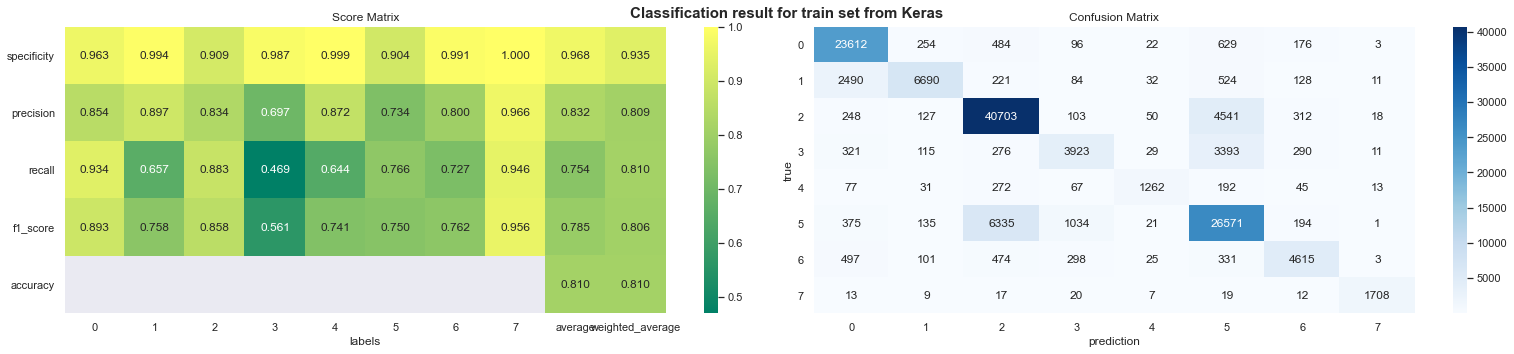

In [83]:
y_pred = model.predict(X_train).argmax(axis=1)
score,conf = msd.class_result(y_train.values.argmax(axis=1), y_pred,out_confus = True)

score = get_weighted_scores(score, y_train.values.argmax(axis=1))
display(score)
display(conf)
setname = "train set"
plot_tables(score, conf, setname, modelname, savedir)


labels,0,1,2,3,4,5,6,7,average,weighted_average
specificity,0.959092,0.989633,0.902977,0.981626,0.997552,0.894552,0.987558,0.999251,0.964030,0.929572
precision,0.841915,0.832410,0.820850,0.570465,0.773050,0.709397,0.721021,0.942824,0.776491,0.778287
recall,0.915105,0.619890,0.870063,0.383375,0.552738,0.739377,0.658252,0.914027,0.706604,0.782668
f1_score,0.876986,0.710600,0.844741,0.458572,0.644589,0.724077,0.688208,0.928202,0.734497,0.777230
accuracy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.782668,0.782668


prediction,0,1,2,3,4,5,6,7
true,,,,,,,,
0,11674,214,277,68,29,372,119,4
1,1342,3154,112,57,18,308,89,8
2,156,91,19519,83,47,2337,191,10
3,170,75,176,1522,12,1835,177,3
4,31,42,162,49,545,108,39,10
5,243,123,3203,703,18,12667,167,8
6,242,83,314,168,29,214,2034,6
7,8,7,16,18,7,15,5,808


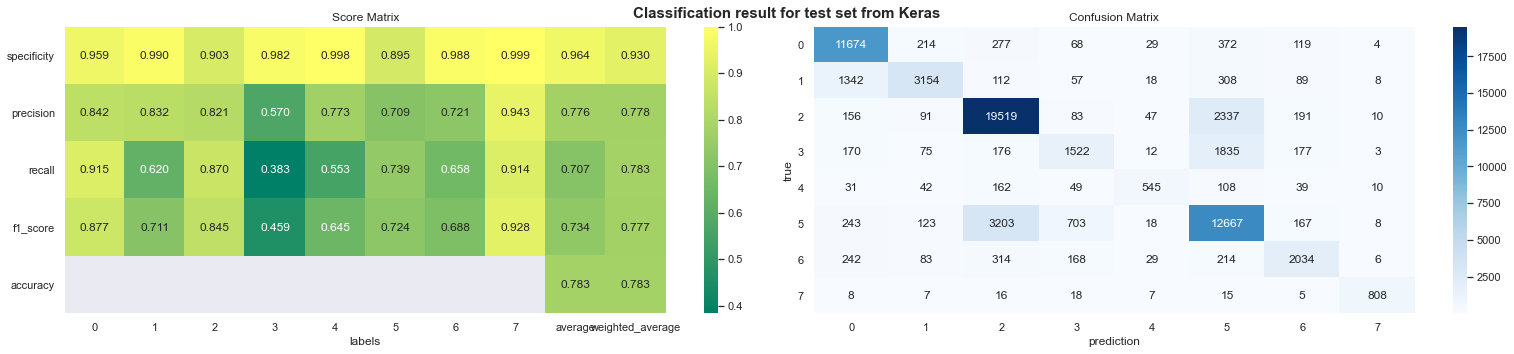

In [84]:
y_pred = model.predict(X_test).argmax(axis=1)
score,conf = msd.class_result(y_test.values.argmax(axis=1), y_pred,out_confus = True)

score = get_weighted_scores(score, y_test.values.argmax(axis=1))
display(score)
display(conf)
setname = "test set"

plot_tables(score, conf, setname, modelname, savedir)


In [80]:
#This is the example code to explain how to use the above function.


# # example code
# result, confus = msd.class_result(y_test, y_pred, True)
# result = get_weighted_score(result, y_test)
# setname = 'train-data'
# modelname = 'Keras'
# savedir = 'Desktop'
# plot_table(result, confus, setname, modelname, savedir)